In [104]:
# use gpd_2023 environment

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
# now get AUROC and average precision for the probas and mse for the ln's
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, brier_score_loss

import pandas as pd

# Test: Df to vol, vol to df

Lest check that we can load the df, create a volumn, and then recreate af df again

### Functions

In [2]:
def df_to_vol(df):
    """
    Converts a DataFrame into a 4D volume array for spatial-temporal data representation.
    The volume array is [height, width, n_months, n_features].

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data with columns
                           'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 'row',
                           'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', and 'ln_os_best'.

    Returns:
        np.ndarray: The volume representation of the DataFrame with shape 
                    [n_months, height, width, n_features].
                    The specific shape will be [n_months, 180, 180, 8].
    """
    month_first = df['month_id'].min()
    month_last = df['month_id'].max()
    month_range = month_last - month_first + 1
    space_range = 180
    features_num = 8  # Should match the number of features in the DataFrame

    vol = np.zeros([space_range, space_range, month_range, features_num])

    vol[df['abs_row'], df['abs_col'], df['abs_month'], 0] = df['pg_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 1] = df['col']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 2] = df['row']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 3] = df['month_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 4] = df['c_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 5] = df['ln_sb_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 6] = df['ln_ns_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 7] = df['ln_os_best']

    vol = np.flip(vol, axis=0)  # Flip the rows, so north is up.
    vol = np.transpose(vol, (2, 0, 1, 3))  # Move the month dimension to the front.

    print(f'Volume of shape {vol.shape} created. Should be (n_months, 180, 180, 8)')

    return vol


In [3]:
def vol_to_df(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best': vol[:, :, :, 5].flatten(),
        'ln_ns_best': vol[:, :, :, 6].flatten(),
        'ln_os_best': vol[:, :, :, 7].flatten()
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [4]:
def df_vol_test(df, vol):
    """
    Unit test to verify the conversion between DataFrame and volume array.
    Checks if the original DataFrame and the DataFrame created from the volume are equivalent.

    Args:
        df (pd.DataFrame): The original DataFrame.
        vol (np.ndarray): The 4D volume array created from the DataFrame.

    Returns:
        None: Prints the result of the equivalence test.
    """
    # Make a copy of the original DataFrame
    df_copy = df.copy()

    # Proof of concept: Check if the copy is the same as the original
    print("Original DataFrame equals its copy:", df.equals(df_copy))

    # Convert the volume back into a DataFrame
    df_recreated = vol_to_df(vol)

    # Trim the original DataFrame to match the features of the recreated DataFrame
    df_trimmed = df[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

    # Sort both DataFrames by 'pg_id' and 'month_id'
    df_trimmed = df_trimmed.sort_values(by=['pg_id', 'month_id'])
    df_recreated = df_recreated.sort_values(by=['pg_id', 'month_id'])

    # Reset the index to ensure alignment
    df_trimmed = df_trimmed.reset_index(drop=True)
    df_recreated = df_recreated.reset_index(drop=True)

    # Check if the two DataFrames are the same
    is_equal = df_trimmed.equals(df_recreated)
    print("Trimmed original DataFrame equals recreated DataFrame from volume:", is_equal)


In [5]:
def plot_vol(vol, month_range):
    """
    Plots slices of the 4D volume array for the specified month range.
    Displays different feature maps for each time step in separate subplots.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        month_range (int): The number of slices (time steps) to plot.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # get sub_df of the lasst month_range months
    vol = vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(1, n_features, figsize=(20, 4))
        
        for j in range(min(n_features, vol.shape[-1])):  # Handle cases where there are fewer than 7 features
            im = ax[j].imshow(vol[i, :, :, j], cmap='rainbow', vmin= vol[:, :, :, j].min(), vmax= vol[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            # plt.colorbar(im, ax=ax[j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # remove ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.1, right=1, top=0.85, bottom=0.55, wspace=0.2, hspace=-0)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.9])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute


Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Original DataFrame equals its copy: True
DataFrame of shape (4247640, 8) created. Should be (n_months * 180 * 180, 8)
Trimmed original DataFrame equals recreated DataFrame from volume: True


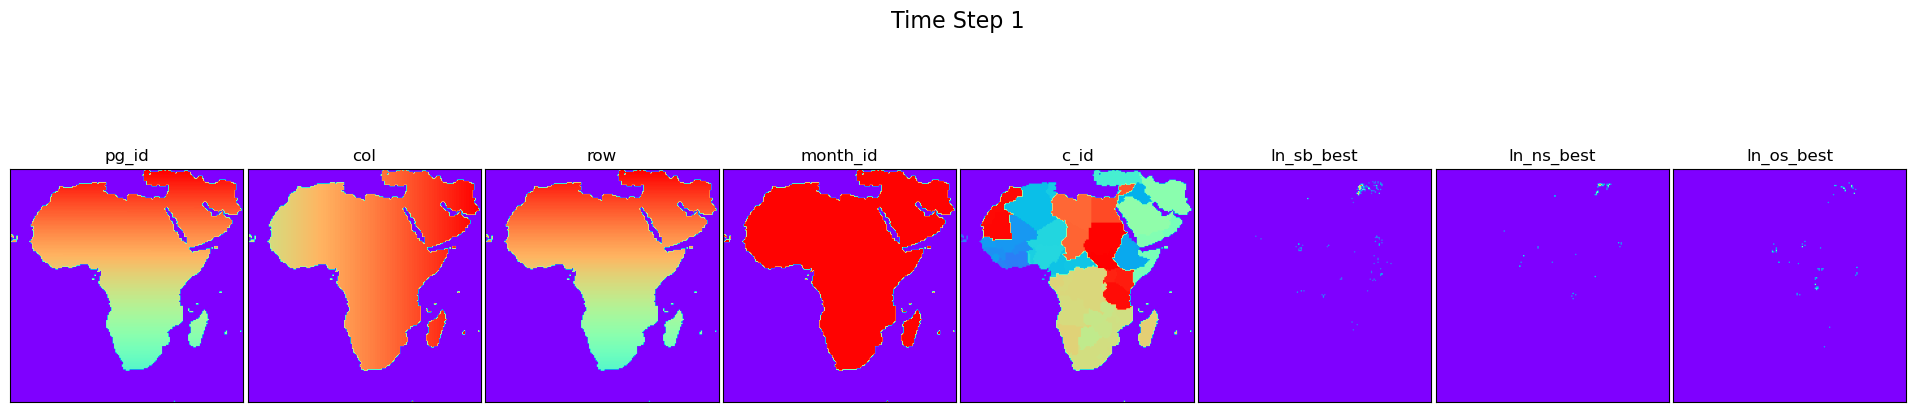

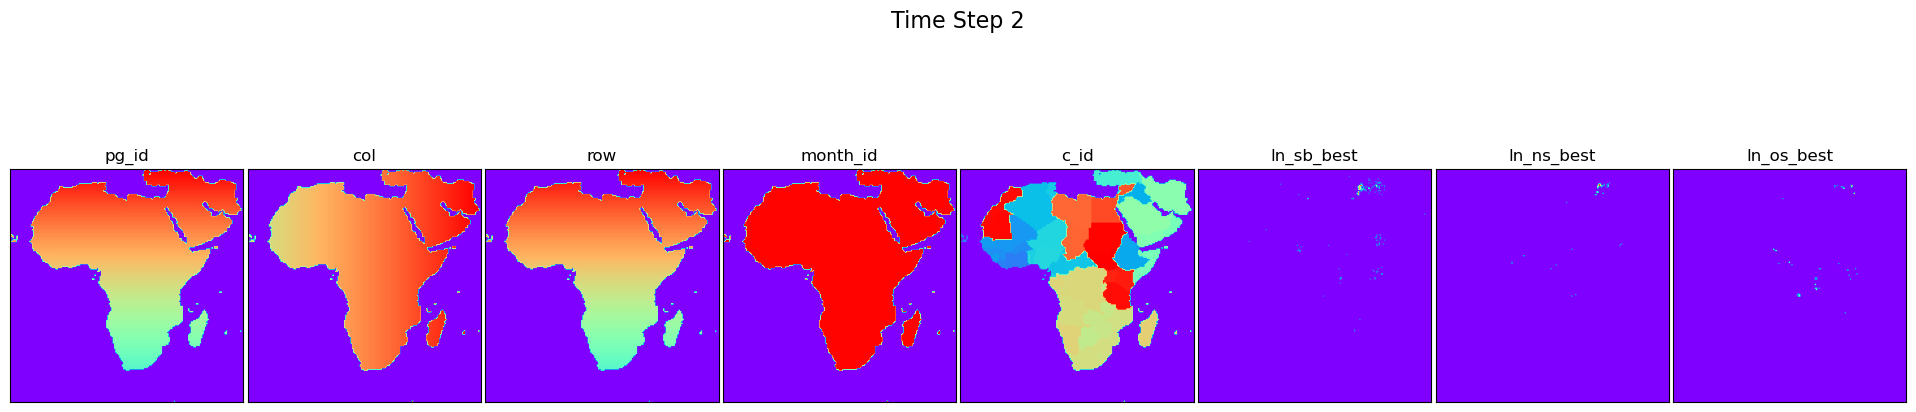

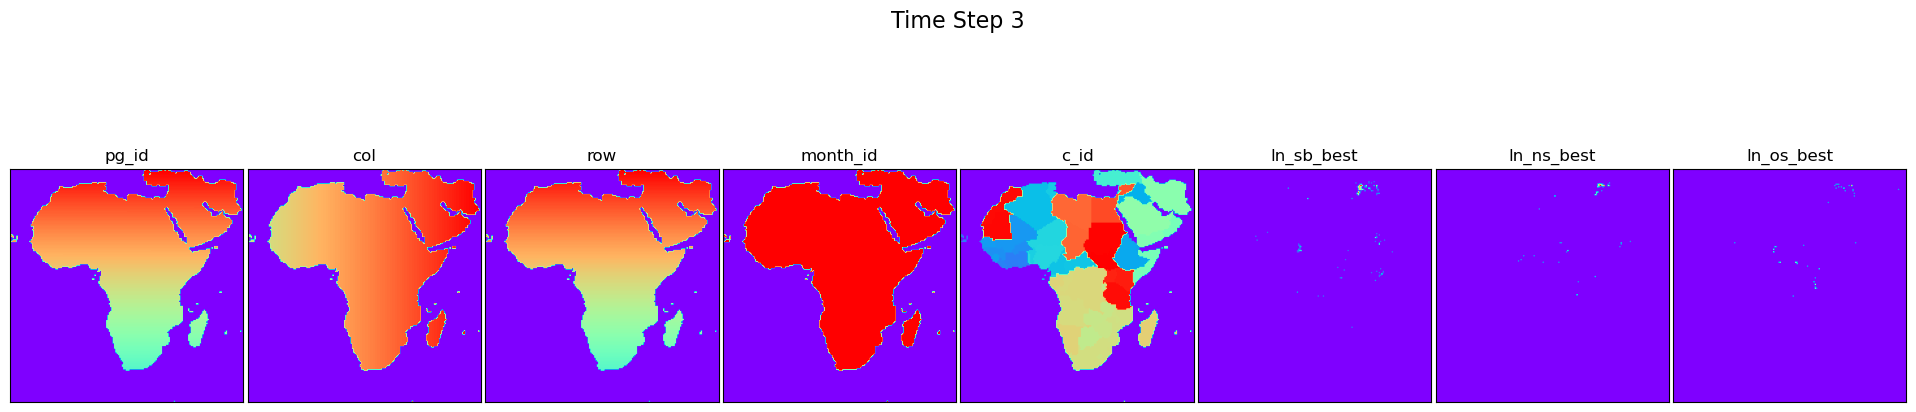

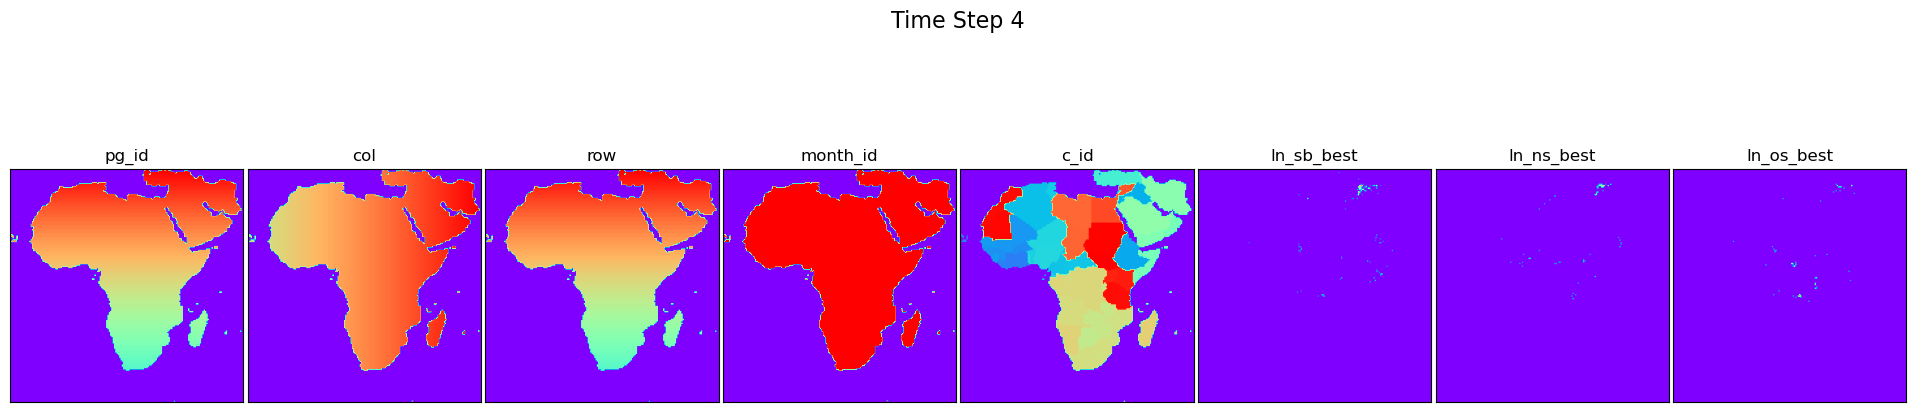

In [6]:
# set the path to the raw data
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_test(df, vol)

plot_vol(vol, 4)

# forecast storage test
Now we test how we can make a storage array for the 4D forcast

### Functions

In [7]:
def generate_fake_vol(vol, month_range=36):
    """
    Generates a fake prediction volume for testing purposes by extracting the last three features from the input volume.
    Assumes the last three features represent `sb`, `ns`, and `os`.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        n_months (int): The number of months to include in the fake volume. Default is 36.

    Returns:
        np.ndarray: A volume array with the last three features, shape [32, height, width, 3].
                    Represents a subset of the original volume for testing.
    """
    # Extract the last three features from the volume
    fake_vol = vol[-month_range:, :, :, 5:]  

    return fake_vol


In [8]:
def make_forecast_storage_vol(df, month_range = 36, true_forecast = False):
    """
    Creates a forecast storage volume based on the last month of data in the DataFrame.
    The volume is repeated for the specified `month_range` with incrementally adjusted month IDs.

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data.
                           Expected columns include 'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 
                           'row', 'month_id', 'c_id'.
        month_range (int): The number of months to forecast into the future. Default is 36.

    Returns:
        np.ndarray: The forecast storage volume with shape [month_range, 180, 180, 5].
                    Each time slice in the volume represents a future month based on the last month of data.
    """
    # Infer the last month_id from the DataFrame
    last_month_id = df['month_id'].max()

    # Create a sub DataFrame of only the last month
    sub_df = df[df['month_id'] == last_month_id].copy()

    # Initialize the volume array
    space_range = 180
    features_num = 5  # Adjust this based on the number of features you have

    # Create the zero array with only the last month
    vol = np.zeros([space_range, space_range, 1, features_num])

    # Adjust abs_month to 0 for the initial volume
    sub_df['adjusted_abs_month'] = 0

    # Populate the volume array with the data from the DataFrame
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 0] = sub_df['pg_id']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 1] = sub_df['col']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 2] = sub_df['row']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 3] = sub_df['month_id'] 
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 4] = sub_df['c_id']

    # Stack the volume to the desired month range
    vol = np.repeat(vol, month_range, axis=2)

#    if true_forecast:
    # Adjust the month_id with an increment of 1
 #       for i in range(month_range):
            #vol[:, :, i, 3] = last_month_id + i + 1 # to get one month after the last observed month

#    else:
#        pass


    # THIS IS A WIERD THING AND THERE COULD BE A BUG HERE.... :
    # Adjust the month_id with an increment of 1
    for i in range(month_range):
        vol[:, :, i, 3] = last_month_id + i + 1 # to get one month after the last observed month

    # Reorient and transpose
    vol = np.flip(vol, axis=0)
    vol = np.transpose(vol, (2, 0, 1, 3))

    print(f'Volume of shape {vol.shape} created. Should be ({month_range}, 180, 180, {features_num})')

    return vol

In [9]:
def merge_vol(forecast_storage_vol, vol_fake):
    """
    Merges a forecast volume with an existing forecast storage volume.
    Combines the features from `vol_fake` with `vol` along the feature axis.

    Args:
        vol (np.ndarray): The forecast storage volume with shape [n_months, height, width, n_features].
        vol_fake (np.ndarray): The forecast volume to be merged with shape [n_months, height, width, n_features_fake].

    Returns:
        np.ndarray: The merged volume with shape [n_months, height, width, n_features + n_features_fake].
    """
    # Merge the forecast volume with the storage volume along the feature axis
    full_vol = np.concatenate([forecast_storage_vol, vol_fake], axis=-1)

    # print the shape of the full volume
    print(f'Volume of shape {full_vol.shape} created. Should be ({forecast_storage_vol.shape[0]}, 180, 180, {forecast_storage_vol.shape[3] + vol_fake.shape[3]})')

    return full_vol


In [10]:
def check_vol_equal(vol, full_vol):
    """
    Unit test to verify the merging of two volumes.
    Checks if the original volume and the merged volume are equivalent.

    Args:
        vol (np.ndarray): The original volume.
        full_vol (np.ndarray): The merged volume.

    Returns:
        None: Prints the result of the equivalence test.
    """

    #print the shape of the volumes
    print(vol.shape)
    print(full_vol.shape)

    # trim original volume to the same shape as the full volume - ie. the last n months
    month_range = full_vol.shape[0]
    vol_trimmed = vol[-month_range:, :, :, :]

    # print the shape of the trimmed volume
    print(vol_trimmed.shape)

    # now go through each feature individually and check if they are the same

    list_features = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']

    for i in range(vol_trimmed.shape[-1]):
        print(f"Feature {i}, {list_features[i]} equal:", np.array_equal(vol_trimmed[:, :, :, i], full_vol[:, :, :, i]))


In [11]:
def plot_vol_comparison(vol, new_vol, month_range=36):
    """
    Plots a comparison of slices from two 4D volume arrays for the specified month range.
    Displays different feature maps for each time step in separate subplots for both volumes.

    Args:
        vol (np.ndarray): The original 4D volume array with shape [n_months, height, width, n_features].
        new_vol (np.ndarray): The new 4D volume array to compare with, with the same shape as `vol`.
        month_range (int): The number of slices (time steps) to plot. Default is 36.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # Ensure the volumes cover the last month_range months
    vol = vol[-month_range:, :, :, :]
    new_vol = new_vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(2, n_features, figsize=(20, 7))  # 2 rows, n_features columns
        
        for j in range(n_features):  # Adjusted to use n_features directly
            # Plot the original volume in the first row
            im1 = ax[0, j].imshow(vol[i, :, :, j], cmap='rainbow',
                                  vmin=vol[:, :, :, j].min(), vmax=vol[:, :, :, j].max())
            ax[0, j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            #plt.colorbar(im1, ax=ax[0, j])

            # Plot the new volume in the second row
            im2 = ax[1, j].imshow(new_vol[i, :, :, j], cmap='rainbow',
                                  vmin=new_vol[:, :, :, j].min(), vmax=new_vol[:, :, :, j].max())
            ax[1, j].set_title(f'New {features_titles[j]}' if j < len(features_titles) else f'New Feature {j}')
            #plt.colorbar(im2, ax=ax[1, j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # Remove ticks
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.4)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.95])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute

In [12]:
month_range = 36

vol_fake = generate_fake_vol(vol, month_range=month_range)

#print shape of vol_fake
print(vol_fake.shape)

# make the forecast storage volume
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

#print shape of forecast_storage_vol
print(forecast_storage_vol.shape)

# merge the forecast storage volume with the forecast volume
new_vol = merge_vol(forecast_storage_vol, vol_fake)

#print shape of full_vol
print(new_vol.shape)

# Check that the full vol is equal to the original vol (sliced correctly)
check_vol_equal(vol, new_vol)

# plot the volume slices
# plot_vol_comparison(vol, new_vol, month_range=month_range) # works and cornfirms that the two volumes are the same (except for month_id, which is expected)

(36, 180, 180, 3)
Volume of shape (36, 180, 180, 5) created. Should be (36, 180, 180, 5)
(36, 180, 180, 5)
Volume of shape (36, 180, 180, 8) created. Should be (36, 180, 180, 8)
(36, 180, 180, 8)
(324, 180, 180, 8)
(36, 180, 180, 8)
(36, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True


So we can now construct the vol form a df, and we can reconstruct the df from the vol. We can also make a forecasting storage and merge that with (fake) predictions to get a vol similar to the original vol. Now must take that back to a df. 

# new_vol to df

Now, create a new vol and make into a df and ceck that this df can corrospond to the original df

In [13]:
# Lets start from scracth
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
df = pd.read_pickle(PATH)

vol = df_to_vol(df)

vol_fake = generate_fake_vol(vol, month_range=month_range)

forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

new_vol = merge_vol(forecast_storage_vol, vol_fake)

check_vol_equal(vol, new_vol)

df_new = vol_to_df(new_vol)

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Volume of shape (36, 180, 180, 5) created. Should be (36, 180, 180, 5)
Volume of shape (36, 180, 180, 8) created. Should be (36, 180, 180, 8)
(324, 180, 180, 8)
(36, 180, 180, 8)
(36, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True
DataFrame of shape (471960, 8) created. Should be (n_months * 180 * 180, 8)


In [14]:
print(df["month_id"].max())
(df_new["month_id"].min())


444


445

In [15]:
df_new

,pg_id,col,row,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best
284,190494,414,265,445,89,0.0,0.0,0.0
285,190495,415,265,445,89,0.0,0.0,0.0
286,190496,416,265,445,89,0.0,0.0,0.0
297,190507,427,265,445,96,0.0,0.0,0.0
298,190508,428,265,445,96,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1161822,80332,412,112,480,163,0.0,0.0,0.0
1161989,79599,399,111,480,163,0.0,0.0,0.0
1161990,79600,400,111,480,163,0.0,0.0,0.0
1161991,79601,401,111,480,163,0.0,0.0,0.0


In [16]:
month_range = 36
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

# only keep the features that are in the new volume
df_sub = df_sub[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

df_sub 

,pg_id,col,row,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best
5348880,62356,436,87,409,163,0.0,0.0,0.0
5348881,79599,399,111,409,163,0.0,0.0,0.0
5348882,79600,400,111,409,163,0.0,0.0,0.0
5348883,79601,401,111,409,163,0.0,0.0,0.0
5348884,80317,397,112,409,163,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5820835,190496,416,265,444,89,0.0,0.0,0.0
5820836,190507,427,265,444,96,0.0,0.0,0.0
5820837,190508,428,265,444,96,0.0,0.0,0.0
5820838,190510,430,265,444,96,0.0,0.0,0.0


In [17]:
# now sort both dataframes by pg_id and month_id
df_sub = df_sub.sort_values(by=['pg_id', 'month_id'])
df_new = df_new.sort_values(by=['pg_id', 'month_id'])

# check which columns are not equal 
for i in range(df_sub.shape[1]):
    print(f"Feature {i}, {df_sub.columns[i]} equal:", np.array_equal(df_sub.iloc[:, i], df_new.iloc[:, i]))

Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True


Looking good. Now we need to add actual predictions instead of "fake_predictions" which were just the last subset of observations. 

# posterior dict to vol to df...
Load the correct posterio_dict and the original df (you could prolly use the saved vol, but fuck it)

### functions
just some small changes to the functions above

In [18]:
def vol_to_df_new(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_pred': vol[:, :, :, 5].flatten(),
        'ln_ns_pred': vol[:, :, :, 6].flatten(),
        'ln_os_pred': vol[:, :, :, 7].flatten(),
        'proba_os_pred': vol[:, :, :, 8].flatten(),
        'proba_ns_pred': vol[:, :, :, 9].flatten(),
        'proba_sb_pred': vol[:, :, :, 10].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [70]:
def vol_to_df_oos(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best_oos': vol[:, :, :, 5].flatten(),
        'ln_ns_best_oos': vol[:, :, :, 6].flatten(),
        'ln_os_best_oos': vol[:, :, :, 7].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df

In [71]:
# lets start from scratch again

PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36 # but what even is it in the partion by now?

In [72]:
# get the three lists from the posterior_dict
posterior_list, posterior_list_class, out_of_sample_vol = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

# the posterior_list is a list of list of arrays
# the first list is the number of draws from the posterior
# the second list is the number of months in the forecast
# the arrays are the forecasted volumes for size 3x180x180

In [111]:
def get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol):

    """Return a dictionary of metrics for the monthly out-of-sample predictions for W&B."""

    log_dict = {}
    log_dict["monthly/out_sample_month"] = i


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier

    return log_dict

In [115]:
# OKAY! lets start with the thing from eval
# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

out_sample_month_list = [] # only used for pickle...
ap_list = []
mse_list = []
auc_list = []
brier_list = []

#NEW
log_dict_list = []

for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

    y_score = mean_array[i].reshape(-1) # make it 1d  # nu 180x180
    y_score_prob = mean_class_array[i].reshape(-1) # nu 180x180

    # do not really know what to do with these yet.
    y_var = std_array[i].reshape(-1)  # nu 180x180
    y_var_prob = std_class_array[i].reshape(-1)  # nu 180x180

    y_true = out_of_sample_vol[:,i].reshape(-1)  # nu 180x180 . dim 0 is time
    y_true_binary = (y_true > 0) * 1

    # log the metrics to WandB - but why here? 
    log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol)# so at least it gets reported sep.
    log_dict_list.append(log_dict)

    #wandb.log(log_dict)

    # YOU KNOW THIS IS WRONG ALREADY!!!!

#    # this could be a function in utils_wandb or in common_utils... 
#    mse = mean_squared_error(y_true, y_score)  
#    ap = average_precision_score(y_true_binary, y_score_prob)
#    auc = roc_auc_score(y_true_binary, y_score_prob)
#    brier = brier_score_loss(y_true_binary, y_score_prob)
#
#    out_sample_month_list.append(i) # only used for pickle...
#    mse_list.append(mse)
#    ap_list.append(ap) # add to list.
#    auc_list.append(auc)
#    brier_list.append(brier)
#

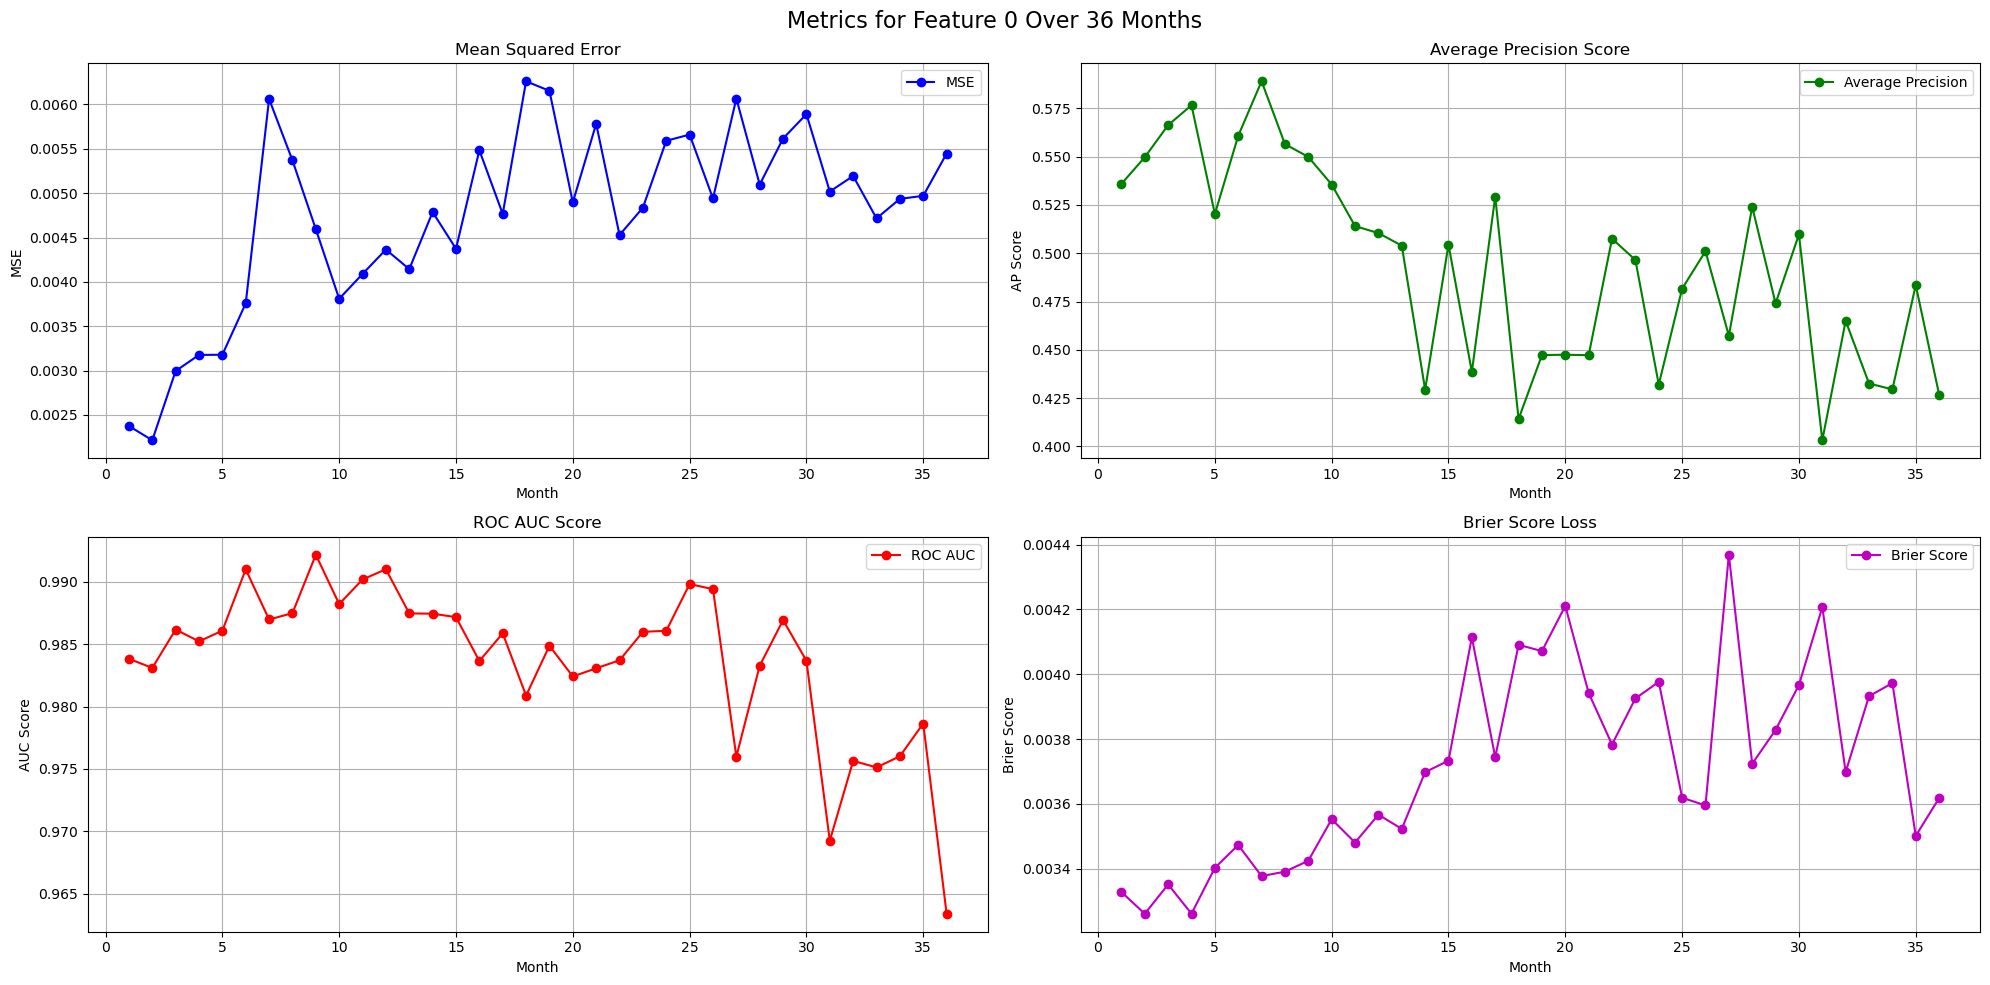

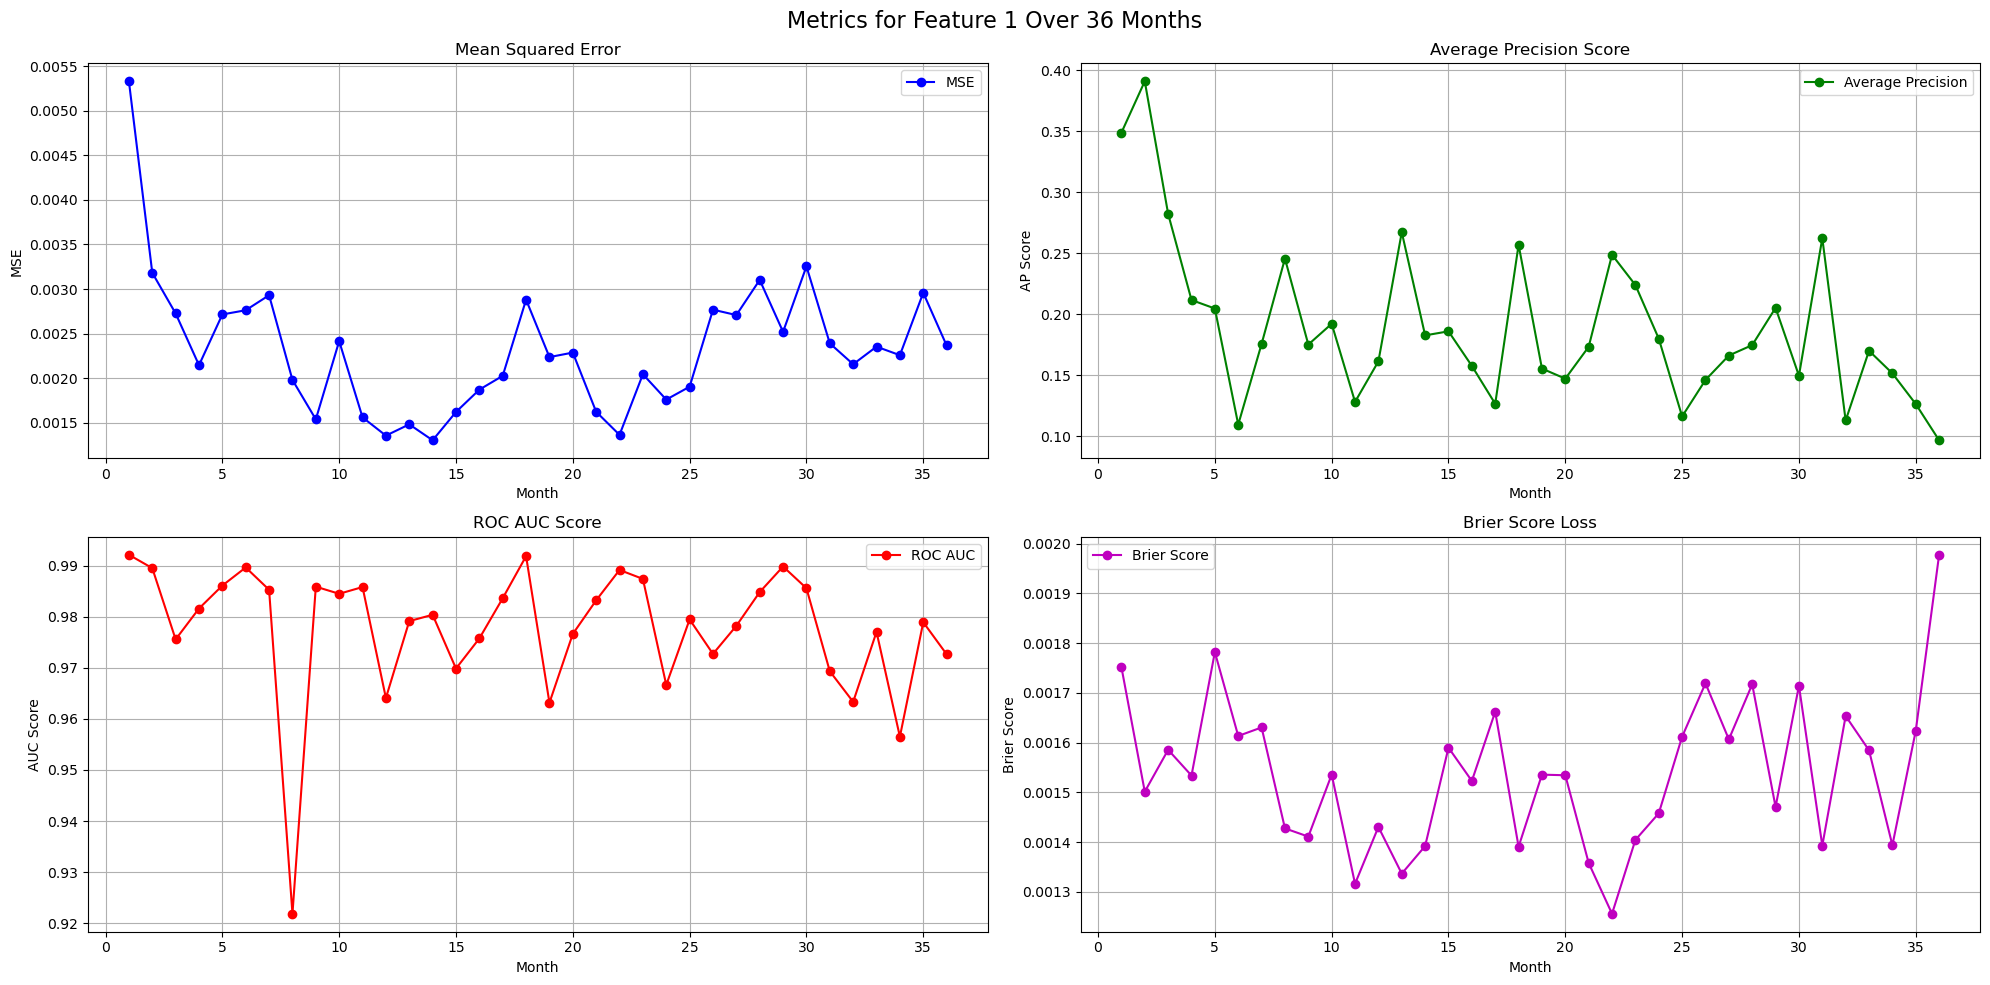

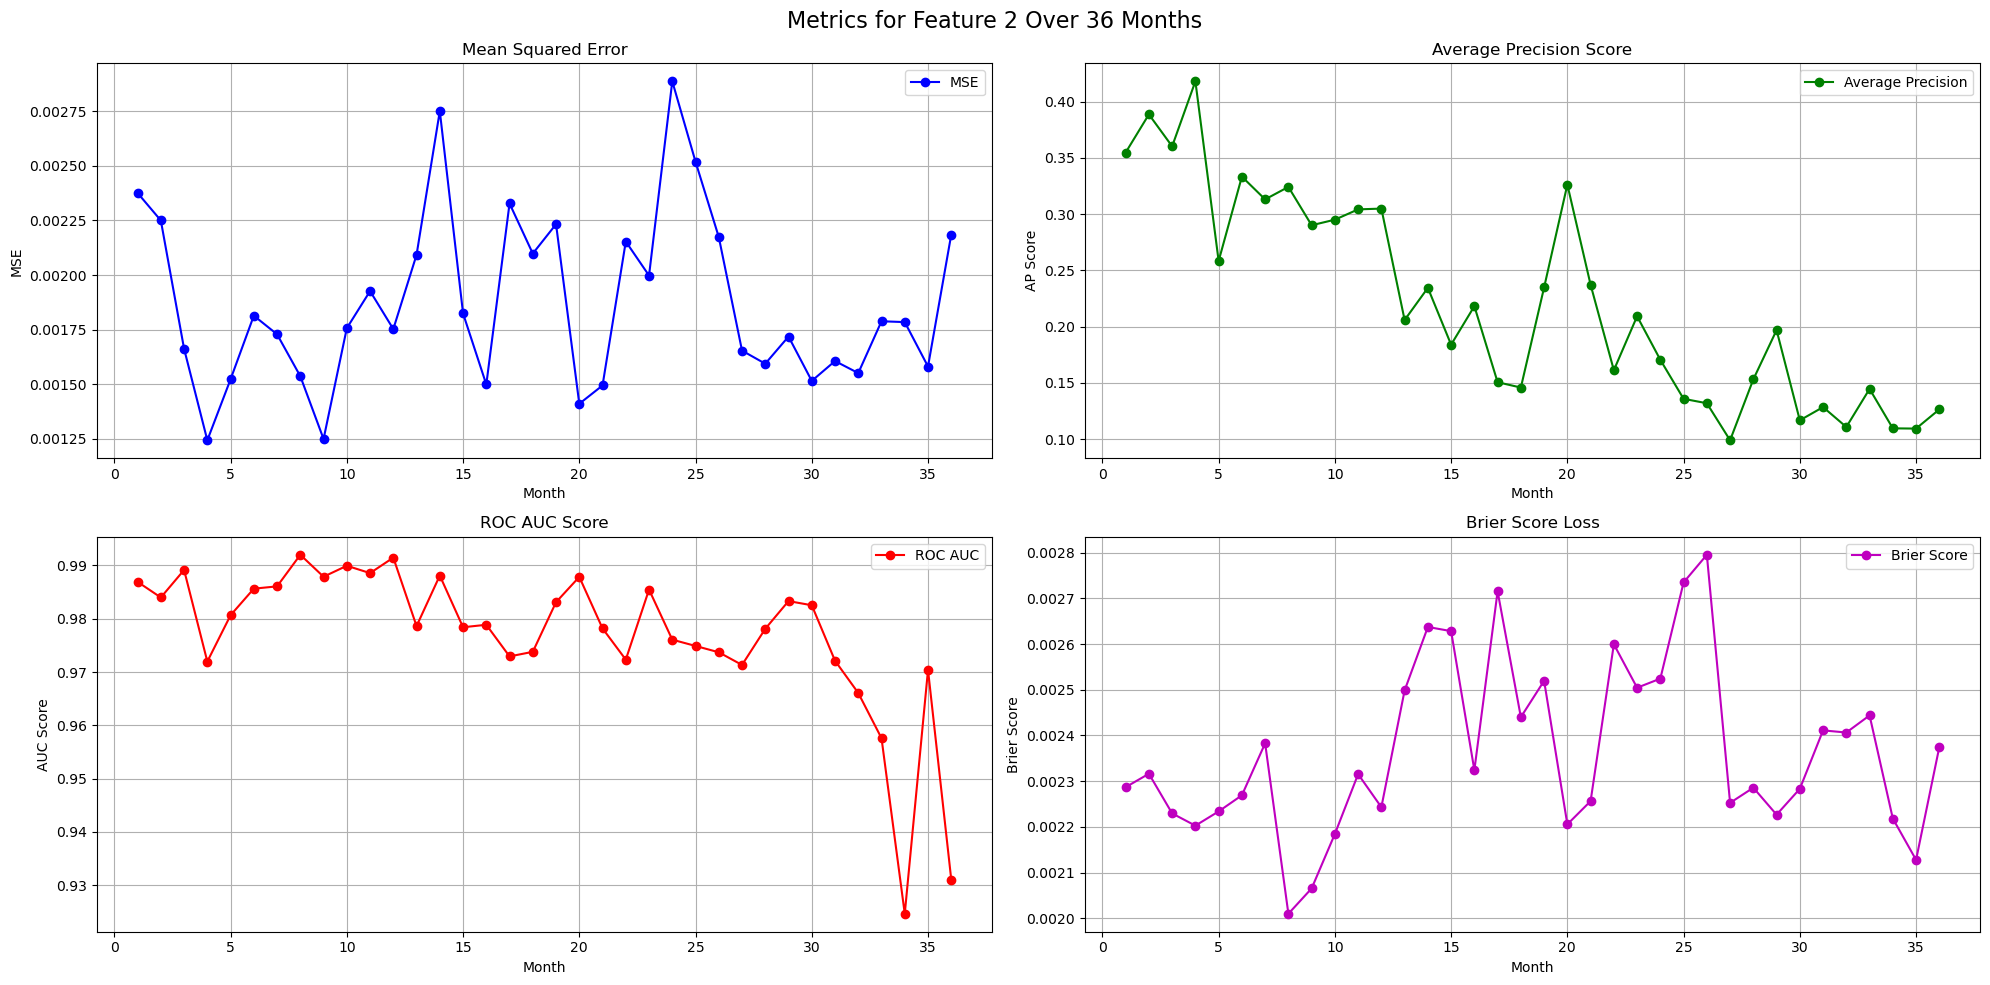

In [130]:
def plot_metrics(log_dict_list, num_months, feature = 0):
    """
    Plots MSE, Average Precision, ROC AUC, and Brier Score for each month from log_dict_list.

    Args:
        log_dict_list (list of dict): List of dictionaries with monthly metrics.
        num_months (int): Number of months to plot.
    """

    # Initialize lists to store metrics for each month
    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    # Iterate over the log_dict_list and extract the metrics
    for i in range(num_months):
        mse_list.append(log_dict_list[i][f'monthly/mean_squared_error{feature}'])
        ap_list.append(log_dict_list[i][f'monthly/average_precision_score{feature}'])
        auc_list.append(log_dict_list[i][f'monthly/roc_auc_score{feature}'])
        brier_list.append(log_dict_list[i][f'monthly/brier_score_loss{feature}'])

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Plot MSE
    axs[0, 0].plot(range(1, len(mse_list) + 1), mse_list, marker='o', color='b', label='MSE')
    axs[0, 0].set_title('Mean Squared Error')
    axs[0, 0].set_xlabel('Month')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Average Precision
    axs[0, 1].plot(range(1, len(ap_list) + 1), ap_list, marker='o', color='g', label='Average Precision')
    axs[0, 1].set_title('Average Precision Score')
    axs[0, 1].set_xlabel('Month')
    axs[0, 1].set_ylabel('AP Score')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot ROC AUC
    axs[1, 0].plot(range(1, len(auc_list) + 1), auc_list, marker='o', color='r', label='ROC AUC')
    axs[1, 0].set_title('ROC AUC Score')
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('AUC Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot Brier Score
    axs[1, 1].plot(range(1, len(brier_list) + 1), brier_list, marker='o', color='m', label='Brier Score')
    axs[1, 1].set_title('Brier Score Loss')
    axs[1, 1].set_xlabel('Month')
    axs[1, 1].set_ylabel('Brier Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # add a title
    plt.suptitle(f'Metrics for Feature {feature} Over {num_months} Months', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()


# Example usage:
plot_metrics(log_dict_list, 36, 0)

# Example usage:
plot_metrics(log_dict_list, 36, 1)

# Example usage:
plot_metrics(log_dict_list, 36, 2)


In [119]:
# now plot from the log_dict

# iterate over the log_dict_list and plot the metrics for each month
for i in range(36): # should be infered
    print(f"Month {i}")
    print(f"MSE: {log_dict_list[i]['monthly/mean_squared_error0']}")
    print(f"AP: {log_dict_list[i]['monthly/average_precision_score0']}")
    print(f"AUC: {log_dict_list[i]['monthly/roc_auc_score0']}")
    print(f"Brier: {log_dict_list[i]['monthly/brier_score_loss0']}")

Month 0
MSE: 0.0023753305431455374
AP: 0.5359263342818636
AUC: 0.9838299012255511
Brier: 0.003328142526672374
Month 1
MSE: 0.002214475069195032
AP: 0.5497180814618866
AUC: 0.983092438830647
Brier: 0.003261002233930306
Month 2
MSE: 0.002995214192196727
AP: 0.5663519962764164
AUC: 0.9861721065346883
Brier: 0.0033514156264153354
Month 3
MSE: 0.003176630474627018
AP: 0.5766290608686354
AUC: 0.9852250987516687
Brier: 0.0032611884601083632
Month 4
MSE: 0.0031787476036697626
AP: 0.5202884830377943
AUC: 0.9860786935972641
Brier: 0.0034027798268384205
Month 5
MSE: 0.003758030943572521
AP: 0.5608145701600931
AUC: 0.9909951355538342
Brier: 0.003473099506495432
Month 6
MSE: 0.006061804946511984
AP: 0.5890417073162109
AUC: 0.9869779471800487
Brier: 0.00337717603475767
Month 7
MSE: 0.0053699444979429245
AP: 0.5565027302385018
AUC: 0.9874860612067897
Brier: 0.00339096913882792
Month 8
MSE: 0.004594503436237574
AP: 0.5498817930778324
AUC: 0.9921664601404379
Brier: 0.0034245324559960574
Month 9
MSE: 0.

In [73]:
# change the posterior_list to a numpy array of shape (n_draws, n_months, 3, 180, 180)
posterior_array = np.array(posterior_list)
print(posterior_array.shape)

# revesr the order of the months
posterior_array = np.flip(posterior_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_mean = np.mean(posterior_array, axis=0)
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_mean = np.transpose(posterior_mean, (0, 2, 3, 1))
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# and for class
posterior_class_array = np.array(posterior_list_class)
print(posterior_class_array.shape)

# revesr the order of the months
#posterior_class_array = np.flip(posterior_class_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_class_mean = np.mean(posterior_class_array, axis=0)
print(posterior_class_mean.shape)

# reverse the order of the months   
#posterior_class_mean = np.flip(posterior_class_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_class_mean = np.transpose(posterior_class_mean, (0, 2, 3, 1))
print(posterior_class_mean.shape)


(128, 36, 3, 180, 180)
(36, 3, 180, 180)
(36, 180, 180, 3)
(128, 36, 3, 180, 180)
(36, 3, 180, 180)
(36, 180, 180, 3)


In [74]:
# concatenate the posterior_mean and the posterior_class_mean
posterior_all_mean = np.concatenate([posterior_mean, posterior_class_mean], axis=-1)

# reverse the order of the months
#posterior_all_mean = np.flip(posterior_all_mean, axis = 0)

print(posterior_all_mean.shape)

(36, 180, 180, 6)


In [75]:
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

Volume of shape (36, 180, 180, 5) created. Should be (36, 180, 180, 5)


In [76]:
new_vol = merge_vol(forecast_storage_vol, posterior_all_mean)

Volume of shape (36, 180, 180, 11) created. Should be (36, 180, 180, 11)


In [77]:
# what if we merge with the out_of_sample_vol instead?

# remove batch dimension from out_of_sample_vol
out_of_sample_vol_nb = np.squeeze(out_of_sample_vol, axis=0)

# reshape the out_of_sample_vol_nb to be similar to the vol
out_of_sample_vol_nb = np.transpose(out_of_sample_vol_nb, (0, 2, 3, 1))

#merge the out_of_sample_vol_nb with the forecast_storage_vol
new_vol_oos = merge_vol(forecast_storage_vol, out_of_sample_vol_nb)

Volume of shape (36, 180, 180, 8) created. Should be (36, 180, 180, 8)


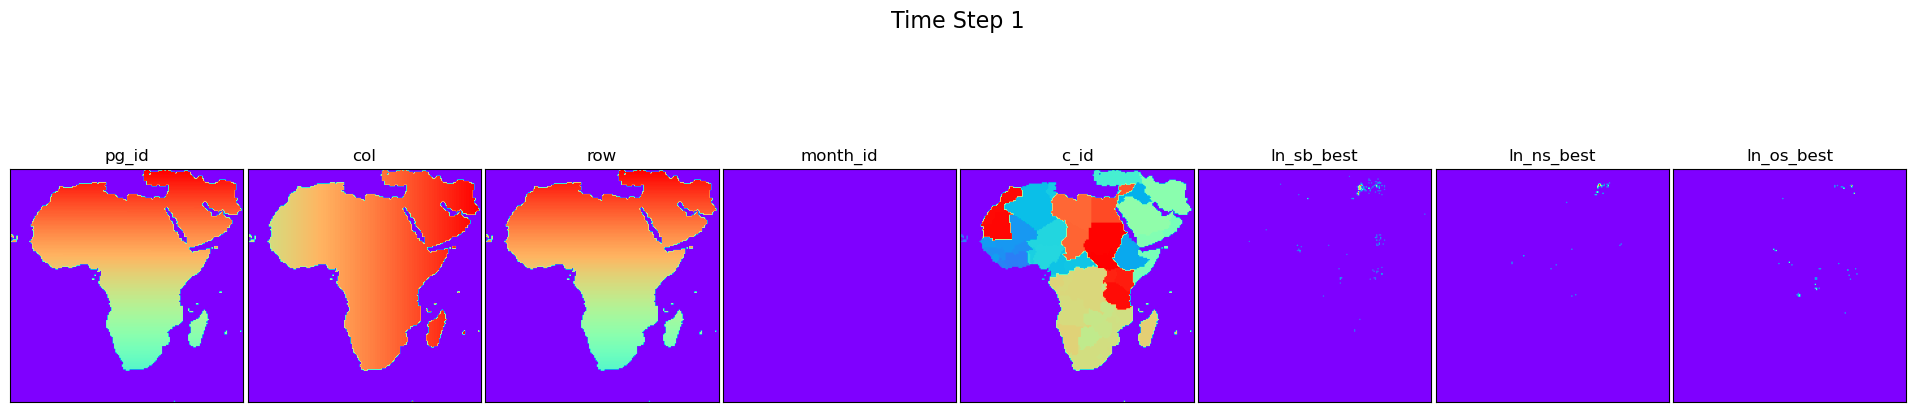

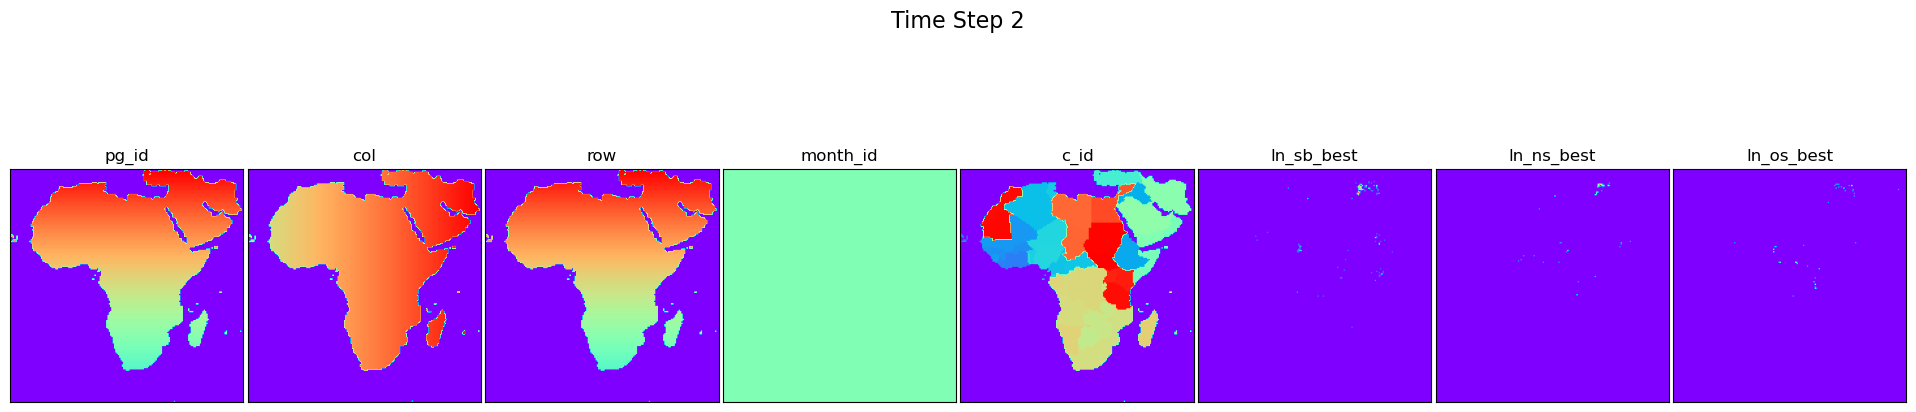

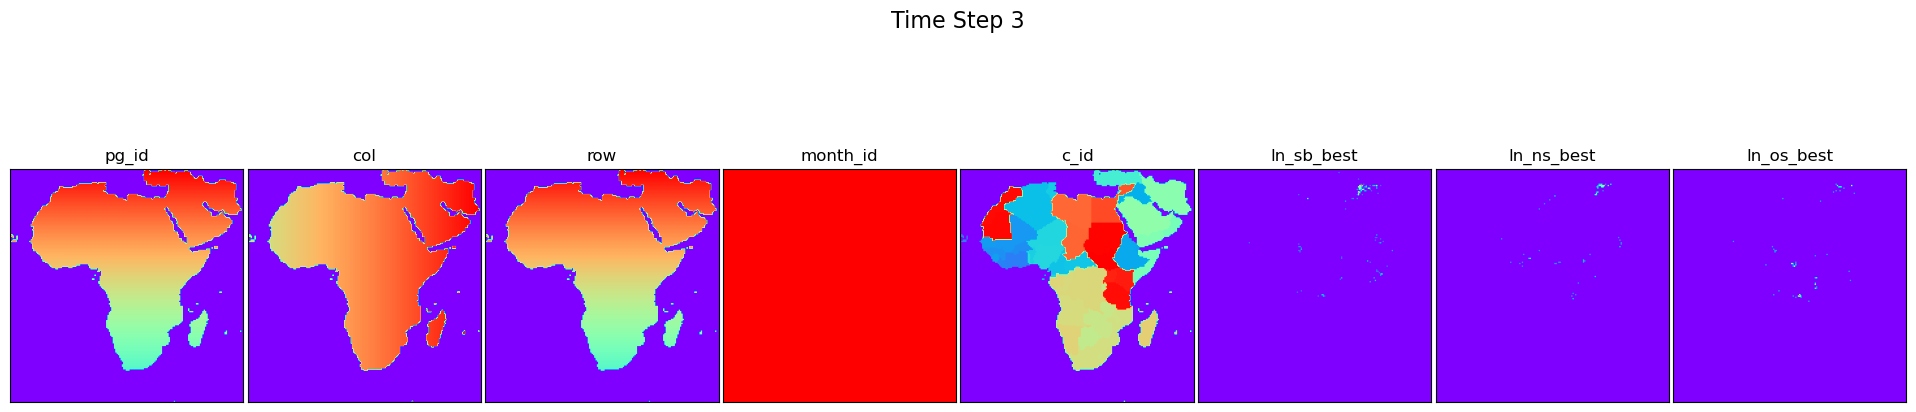

In [78]:
#plot_vol(new_vol, 3)
plot_vol(new_vol_oos, 3)

In [79]:
df_new = vol_to_df_new(new_vol)
df_new_oos = vol_to_df_oos(new_vol_oos)

DataFrame of shape (471960, 11) created. Should be (n_months * 180 * 180, 8)
DataFrame of shape (471960, 8) created. Should be (n_months * 180 * 180, 8)


In [84]:
df_new['month_id'].max()    

480

In [85]:
# so the correctly the df_new have all months_ids moved forward. But since the evaluation set is here part of the original df, I'll just push it back to the original month_ids
df_new["month_id"] = df_new["month_id"] - month_range
print(df_new["month_id"].max())
df_new

444


,pg_id,col,row,month_id,c_id,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_os_pred,proba_ns_pred,proba_sb_pred
284,190494,414,265,409,89,0.0,0.0,0.0,0.013558,0.004687,0.010500
285,190495,415,265,409,89,0.0,0.0,0.0,0.020356,0.006022,0.012333
286,190496,416,265,409,89,0.0,0.0,0.0,0.027460,0.008364,0.019508
297,190507,427,265,409,96,0.0,0.0,0.0,0.009538,0.003074,0.006503
298,190508,428,265,409,96,0.0,0.0,0.0,0.006481,0.002569,0.006217
...,...,...,...,...,...,...,...,...,...,...,...
1161822,80332,412,112,444,163,0.0,0.0,0.0,0.003614,0.001503,0.002464
1161989,79599,399,111,444,163,0.0,0.0,0.0,0.008943,0.002032,0.002838
1161990,79600,400,111,444,163,0.0,0.0,0.0,0.006220,0.001627,0.004396
1161991,79601,401,111,444,163,0.0,0.0,0.0,0.009132,0.001990,0.002452


In [86]:
# now subset the df to only include the last month_range months
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

print(df_sub['month_id'].max())

df_sub

444


,month_id,pg_id,month,year_id,c_id,col,row,ln_sb_best,ln_ns_best,ln_os_best,in_viewser,abs_row,abs_col,abs_month
5348880,409,62356,1,2014,163,436,87,0.0,0.0,0.0,True,0,126,288
5348881,409,79599,1,2014,163,399,111,0.0,0.0,0.0,True,24,89,288
5348882,409,79600,1,2014,163,400,111,0.0,0.0,0.0,True,24,90,288
5348883,409,79601,1,2014,163,401,111,0.0,0.0,0.0,True,24,91,288
5348884,409,80317,1,2014,163,397,112,0.0,0.0,0.0,True,25,87,288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820835,444,190496,12,2016,89,416,265,0.0,0.0,0.0,True,178,106,323
5820836,444,190507,12,2016,96,427,265,0.0,0.0,0.0,True,178,117,323
5820837,444,190508,12,2016,96,428,265,0.0,0.0,0.0,True,178,118,323
5820838,444,190510,12,2016,96,430,265,0.0,0.0,0.0,True,178,120,323


In [87]:
# how does that compare the df_new_oos

# you need to take the month_id back to the oriringal month_id
df_new_oos["month_id"] = df_new_oos["month_id"] - month_range
df_new_oos["month_id"].max()

444

In [89]:
# create a new df (df_merged) which is df_new but with ln_sb_best, ln_ns_best, ln_os_best from df_sub merged by pg_id and month_id

# real
#df_merged = df_new.merge(df_sub[['pg_id', 'month_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']], on=['pg_id', 'month_id'], how='left')

# oos
df_merged = df_new.merge(df_new_oos[['pg_id', 'month_id', 'ln_sb_best_oos', 'ln_ns_best_oos', 'ln_os_best_oos']], on=['pg_id', 'month_id'], how='left')

df_merged

,pg_id,col,row,month_id,c_id,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_os_pred,proba_ns_pred,proba_sb_pred,ln_sb_best_oos,ln_ns_best_oos,ln_os_best_oos
0,190494,414,265,409,89,0.0,0.0,0.0,0.013558,0.004687,0.010500,0.0,0.0,0.0
1,190495,415,265,409,89,0.0,0.0,0.0,0.020356,0.006022,0.012333,0.0,0.0,0.0
2,190496,416,265,409,89,0.0,0.0,0.0,0.027460,0.008364,0.019508,0.0,0.0,0.0
3,190507,427,265,409,96,0.0,0.0,0.0,0.009538,0.003074,0.006503,0.0,0.0,0.0
4,190508,428,265,409,96,0.0,0.0,0.0,0.006481,0.002569,0.006217,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471955,80332,412,112,444,163,0.0,0.0,0.0,0.003614,0.001503,0.002464,0.0,0.0,0.0
471956,79599,399,111,444,163,0.0,0.0,0.0,0.008943,0.002032,0.002838,0.0,0.0,0.0
471957,79600,400,111,444,163,0.0,0.0,0.0,0.006220,0.001627,0.004396,0.0,0.0,0.0
471958,79601,401,111,444,163,0.0,0.0,0.0,0.009132,0.001990,0.002452,0.0,0.0,0.0


In [94]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
#df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

df_merged[['ln_sb_best_oos', 'ln_ns_best_oos', 'ln_os_best_oos', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

,ln_sb_best_oos,ln_ns_best_oos,ln_os_best_oos,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_sb_pred,proba_ns_pred,proba_os_pred
ln_sb_best_oos,1.000000,0.341113,0.368680,0.780168,0.052202,0.632704,0.512203,0.284452,0.543689
ln_ns_best_oos,0.341113,1.000000,0.233074,0.371347,0.166322,0.296853,0.245067,0.270281,0.268049
ln_os_best_oos,0.368680,0.233074,1.000000,0.292537,0.032236,0.294424,0.321838,0.217122,0.302574
ln_sb_pred,0.780168,0.371347,0.292537,1.000000,0.017710,0.802047,0.555774,0.240659,0.569638
ln_ns_pred,0.052202,0.166322,0.032236,0.017710,1.000000,0.014826,0.102737,0.324430,0.082363
ln_os_pred,0.632704,0.296853,0.294424,0.802047,0.014826,1.000000,0.545918,0.236617,0.434158
proba_sb_pred,0.512203,0.245067,0.321838,0.555774,0.102737,0.545918,1.000000,0.637192,0.856286
proba_ns_pred,0.284452,0.270281,0.217122,0.240659,0.324430,0.236617,0.637192,1.000000,0.565823
proba_os_pred,0.543689,0.268049,0.302574,0.569638,0.082363,0.434158,0.856286,0.565823,1.000000


In [32]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

,ln_sb_best,ln_ns_best,ln_os_best,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_sb_pred,proba_ns_pred,proba_os_pred
ln_sb_best,1.000000,0.341113,0.368680,0.780168,0.052202,0.632704,0.512203,0.284452,0.543689
ln_ns_best,0.341113,1.000000,0.233074,0.371347,0.166322,0.296853,0.245067,0.270281,0.268049
ln_os_best,0.368680,0.233074,1.000000,0.292537,0.032236,0.294424,0.321838,0.217122,0.302574
ln_sb_pred,0.780168,0.371347,0.292537,1.000000,0.017710,0.802047,0.555774,0.240659,0.569638
ln_ns_pred,0.052202,0.166322,0.032236,0.017710,1.000000,0.014826,0.102737,0.324430,0.082363
ln_os_pred,0.632704,0.296853,0.294424,0.802047,0.014826,1.000000,0.545918,0.236617,0.434158
proba_sb_pred,0.512203,0.245067,0.321838,0.555774,0.102737,0.545918,1.000000,0.637192,0.856286
proba_ns_pred,0.284452,0.270281,0.217122,0.240659,0.324430,0.236617,0.637192,1.000000,0.565823
proba_os_pred,0.543689,0.268049,0.302574,0.569638,0.082363,0.434158,0.856286,0.565823,1.000000


In [97]:


# binarize the ln's
# class_sb_best = df_merged['ln_sb_best'] > 0
# class_ns_best = df_merged['ln_ns_best'] > 0
# class_os_best = df_merged['ln_os_best'] > 0


# binarize the ln's
class_sb_best = df_merged['ln_sb_best_oos'] > 0
class_ns_best = df_merged['ln_ns_best_oos'] > 0
class_os_best = df_merged['ln_os_best_oos'] > 0

# get the auroc for the probas
auroc_sb = roc_auc_score(class_sb_best, df_merged['proba_sb_pred'])
auroc_ns = roc_auc_score(class_ns_best, df_merged['proba_ns_pred'])
auroc_os = roc_auc_score(class_os_best, df_merged['proba_os_pred'])

# get the average precision for the probas
ap_sb = average_precision_score(class_sb_best, df_merged['proba_sb_pred'])
ap_ns = average_precision_score(class_ns_best, df_merged['proba_ns_pred'])
ap_os = average_precision_score(class_os_best, df_merged['proba_os_pred'])

# get the brier score for the probas
brier_sb = brier_score_loss(class_sb_best, df_merged['proba_sb_pred'])
brier_ns = brier_score_loss(class_ns_best, df_merged['proba_ns_pred'])
brier_os = brier_score_loss(class_os_best, df_merged['proba_os_pred'])

# get the mse for the ln's
mse_sb = mean_squared_error(df_merged['ln_sb_best_oos'], df_merged['ln_sb_pred'])
mse_ns = mean_squared_error(df_merged['ln_ns_best_oos'], df_merged['ln_ns_pred'])
mse_os = mean_squared_error(df_merged['ln_os_best_oos'], df_merged['ln_os_pred'])

# create a nice table with all the results
results = pd.DataFrame({
    'auroc': [auroc_sb, auroc_ns, auroc_os],
    'ap': [ap_sb, ap_ns, ap_os],
    'brier': [brier_sb, brier_ns, brier_os],
    'mse': [mse_sb, mse_ns, mse_os]
}, index=['sb', 'ns', 'os'])

results

,auroc,ap,brier,mse
sb,0.942936,0.362477,0.008237,0.011615
ns,0.954110,0.169184,0.003738,0.005763
os,0.946791,0.178722,0.008599,0.004635


But you are not even sure if the querysets are the same... Should be but are you 100%?

In [98]:
# check how that corropsonds to is we use the out_of_sample_vol

# remove the batch dimension
out_of_sample_vol_no_batch = out_of_sample_vol[0]

# reshape the out_of_sample_vol_no_batch to be similar to the vol
out_of_sample_vol_no_batch = np.transpose(out_of_sample_vol_no_batch, (0, 2, 3, 1))
print(out_of_sample_vol_no_batch.shape)

# now compare this to the 48 month of the vol
vol_3_36 = vol[-month_range:, :, :, 5:]
print(vol_3_36.shape)

# compare the two
print(np.array_equal(out_of_sample_vol_no_batch, vol_3_36))

# but are they near?
print(np.allclose(out_of_sample_vol_no_batch, vol_3_36))


(36, 180, 180, 3)
(36, 180, 180, 3)
False
True


In [99]:
# but is there any correlation between the out_of_sample_vol and the vol_3_48?

# get the corr between the two arrays
print(np.corrcoef(out_of_sample_vol_no_batch.flatten(), vol_3_36.flatten()))


[[1. 1.]
 [1. 1.]]


In [100]:
# what is we forst sum each to see the total sum of the arrays and then substrat one from the other to see what the difference is
print(np.sum(out_of_sample_vol_no_batch))
print(np.sum(vol_3_36))

print(np.sum(out_of_sample_vol_no_batch) - np.sum(vol_3_36)) # Just a rounding error it seems. 

9587.254
9587.253667976012
0.00023827398763387464


In [101]:
# plot placehodlers for the two arrays

In [103]:
# and now month specific metrics..

# first create the list to store the individaul monthly metrics

#auroc
auroc_sb_list = []
auroc_ns_list = []
auroc_os_list = []

#ap
ap_sb_list = []
ap_ns_list = []
ap_os_list = []

#brier
brier_sb_list = []
brier_ns_list = []
brier_os_list = []

#mse
mse_sb_list = []
mse_ns_list = []
mse_os_list = []

month_array = df_merged['month_id'].unique()
#print(month_array)

# loop through the months
for i in month_array:
    #print(i)

    # subset the df_merged to only include the month
    df_sub = df_merged[df_merged['month_id'] == i]

    # binarize the ln's for auroc, ap and brier
    #class_sb_best = df_sub['ln_sb_best'] > 0
    #class_ns_best = df_sub['ln_ns_best'] > 0
    #class_os_best = df_sub['ln_os_best'] > 0

    # binarize the ln's for auroc, ap and brier
    class_sb_best = df_sub['ln_sb_best_oos'] > 0
    class_ns_best = df_sub['ln_ns_best_oos'] > 0
    class_os_best = df_sub['ln_os_best_oos'] > 0

    # get the auroc for the probas and append to the list
    auroc_sb_list.append(roc_auc_score(class_sb_best, df_sub['proba_sb_pred']))
    auroc_ns_list.append(roc_auc_score(class_ns_best, df_sub['proba_ns_pred']))
    auroc_os_list.append(roc_auc_score(class_os_best, df_sub['proba_os_pred']))

    # get the average precision for the probas and append to the list
    ap_sb_list.append(average_precision_score(class_sb_best, df_sub['proba_sb_pred']))
    ap_ns_list.append(average_precision_score(class_ns_best, df_sub['proba_ns_pred']))
    ap_os_list.append(average_precision_score(class_os_best, df_sub['proba_os_pred']))

    # get the brier score for the probas and append to the list
    brier_sb_list.append(brier_score_loss(class_sb_best, df_sub['proba_sb_pred']))
    brier_ns_list.append(brier_score_loss(class_ns_best, df_sub['proba_ns_pred']))
    brier_os_list.append(brier_score_loss(class_os_best, df_sub['proba_os_pred']))

    # get the mse for the ln's and append to the list
    #mse_sb_list.append(mean_squared_error(df_sub['ln_sb_best'], df_sub['ln_sb_pred']))
    #mse_ns_list.append(mean_squared_error(df_sub['ln_ns_best'], df_sub['ln_ns_pred']))
    #mse_os_list.append(mean_squared_error(df_sub['ln_os_best'], df_sub['ln_os_pred']))

    # get the mse for the ln's and append to the list
    mse_sb_list.append(mean_squared_error(df_sub['ln_sb_best_oos'], df_sub['ln_sb_pred']))
    mse_ns_list.append(mean_squared_error(df_sub['ln_ns_best_oos'], df_sub['ln_ns_pred']))
    mse_os_list.append(mean_squared_error(df_sub['ln_os_best_oos'], df_sub['ln_os_pred']))

# create a nice table with all the results
results_month = pd.DataFrame({
    'auroc_sb': auroc_sb_list,
    'auroc_ns': auroc_ns_list,
    'auroc_os': auroc_os_list,
    'ap_sb': ap_sb_list,
    'ap_ns': ap_ns_list,
    'ap_os': ap_os_list,
    'brier_sb': brier_sb_list,
    'brier_ns': brier_ns_list,
    'brier_os': brier_os_list,
    'mse_sb': mse_sb_list,
    'mse_ns': mse_ns_list,
    'mse_os': mse_os_list,
    'moonth_id': month_array
}, index=month_array)

results_month

,auroc_sb,auroc_ns,auroc_os,ap_sb,ap_ns,ap_os,brier_sb,brier_ns,brier_os,mse_sb,mse_ns,mse_os,moonth_id
409,0.957044,0.981172,0.956043,0.379114,0.349317,0.269295,0.007029,0.004259,0.008831,0.006496,0.013224,0.005898,409
410,0.963432,0.975515,0.933523,0.419443,0.391274,0.267793,0.006635,0.003642,0.008848,0.005846,0.007898,0.005705,410
411,0.958391,0.951616,0.962085,0.445675,0.282841,0.281578,0.007247,0.003851,0.008341,0.007628,0.006759,0.004181,411
412,0.963543,0.962441,0.931139,0.459619,0.212153,0.319738,0.006853,0.003724,0.008467,0.007790,0.005298,0.003143,412
413,0.955680,0.967069,0.957521,0.366851,0.205537,0.227607,0.007373,0.004337,0.008334,0.007923,0.006714,0.003710,413
414,0.959588,0.975214,0.955185,0.444892,0.110228,0.281469,0.007699,0.003920,0.008311,0.009354,0.006823,0.004475,414
415,0.956887,0.965441,0.965288,0.461480,0.176363,0.290962,0.007442,0.003962,0.008277,0.014944,0.007232,0.004241,415
416,0.958229,0.883254,0.971554,0.406392,0.246071,0.330195,0.007521,0.003462,0.007591,0.013311,0.004907,0.003768,416
417,0.962033,0.967248,0.969553,0.410832,0.175700,0.263046,0.007671,0.003421,0.007932,0.011173,0.003811,0.003047,417
418,0.955124,0.963813,0.971783,0.418838,0.192834,0.256103,0.007825,0.003729,0.008075,0.009388,0.005962,0.004247,418


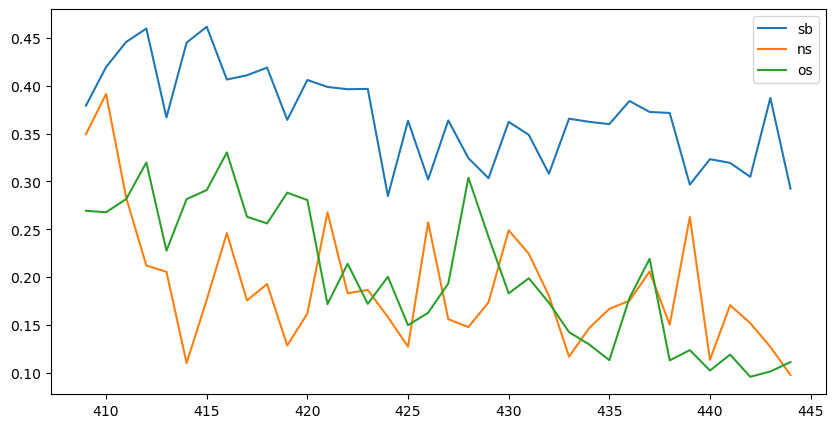

In [39]:
# plot the 3 aps
plt.figure(figsize=(10, 5))

plt.plot(results_month['moonth_id'], results_month['ap_sb'], label='sb')
plt.plot(results_month['moonth_id'], results_month['ap_ns'], label='ns')
plt.plot(results_month['moonth_id'], results_month['ap_os'], label='os')

plt.legend()
plt.show()

# they are recognizably when compared to the WandB but distintly worse... 

So currently I can know if this is right... You need a posterior dict from fimbultuhul which is also evaluation on wieghts and biases